In [4]:
import gmpy2
import numpy as np
from gmpy2 import root, mpfr, cbrt, sqrt, c_div, is_prime, random_state, mpz_urandomb
from gmpy2 import bit_set, next_prime, bit_length, num_digits, mpz_random, gcd
from gmpy2 import invert, powmod, mpz
from gmpy2 import (
    mpz,
    invert,
    powmod,
    random_state,
    mpz_urandomb,
    gcd,
    next_prime,
    bit_set,
)
import time
import random

In [89]:
def get_prime(size):
    seed = random_state(time.time_ns())
    p = mpz_urandomb(seed, size)
    p = p.bit_set(size - 1)
    return next_prime(p)


def get_paillier_keys(size):
    # Genera las claves públicas y privadas del esquema de Paillier.
    p = get_prime(size // 2)
    while True:
        q = get_prime(size // 2)
        if p != q:
            N = p * q
            phi = (p - 1) * (q - 1)
            if gcd(N, phi) == 1:
                break
    g = 1 + N
    pub_key = (N, g)
    priv_key = (phi, max(p, q), min(p, q))
    return pub_key, priv_key


def get_r(pub_key):
    # Genera un valor aleatorio 'r' coprimo con N (la parte del primer elemento de pub_key).
    N = pub_key[0]

    while True:
        # Generamos un número aleatorio con un número de bits similar a N.
        seed = random_state(time.time_ns())
        r = mpz_urandomb(seed, bit_length(N))
        if r != 0 and gcd(r, N) == 1:
            return r


def paillier_encrypt(message, pub_key):  # aqui podrias cambiar por c la salida
    # Cifra un mensaje con la clave pública utilizando el esquema de Paillier.
    N, g = pub_key
    N2 = N**2
    r = get_r(pub_key)
    message = int(message)
    # E(m, r) = g^m * r^N mod N^2
    # c = (powmod(g, message, N2) * powmod(r, N, N2)) % N2
    # Verificar tipos de entrada
    # print(f'Aqui empieza los datos',type(g), type(message), type(N2), type(r), type(N))

    return (powmod(g, message, N2) * powmod(r, N, N2)) % N2


def paillier_decrypt(enc, priv_key, pub_key):
    N = pub_key[0]
    phi = priv_key[0]
    N2 = N**2

    # Calculate L(u) = (u-1)/N
    # First, compute c^phi mod N^2
    c_pow_phi = powmod(enc, phi, N2)

    # Apply L function: L(u) = (u-1)/N
    L_result = ((c_pow_phi - 1) // N) % N

    # Calculate mu = phi^(-1) mod N
    mu = invert(phi, N)

    # Calculate message: m = L(c^phi mod N^2) * mu mod N
    m = (L_result * mu) % N

    return m


In [111]:
# Quantization Index Modulation
# b is the message bit
# w is the premarked watermark
def QIM(w, p, delta=1):
    q_value = p // delta
    if q_value % 2 == w:
        q_value = q_value * delta
    elif p == 255 and w == 0:
        q_value = (q_value - 1) * delta
    elif p == 255 and w == 1:
        q_value = (q_value - 2) * delta
    else:
        q_value = (q_value + 1) * delta
    return q_value


def QIM_extract(p, delta):
    return (p // delta) % 2


def insertion_clair(pwe, b, pub_key):
    be = paillier_encrypt(b, pub_key)

    pweb = (pwe * be) % (pub_key[0] ** 2)
    return pweb


def extraction_clair(image, priv_key, pub_key, w):
    image = image.flatten()
    # Save 256 bits of the image in a list
    pweb = [i for i, j in zip(image, range(256))]
    pweb = np.array(pweb)
    pwb = [paillier_decrypt(i, priv_key, pub_key) for i in pweb]
    b = [int(p % 2) ^ int(wp) for p, wp in zip(pwb, w)]
    return b


def insertion_ciphered(pweb, b, pub_key):
    iteration = 0
    N = pub_key[0]
    N2 = N**2
    while pweb % 2 != b:
        iteration += 1
        E0 = paillier_encrypt(0, pub_key)
        pweb = (pweb * E0) % N2

    return pweb


def extraction_ciphered(image):
    image = image.flatten()
    # Save 256 bits of the image in a list
    bext = [int(i) % 2 for i, j in zip(image, range(256))]

    return bext  # Return b


def permute_with_inverse(arr):
    """Randomly permutes an array and returns both the permuted array and the inverse permutation."""
    n = len(arr)
    indices = np.arange(n)
    permuted_indices = np.random.permutation(indices)  # Generate a random permutation

    permuted_arr = arr[permuted_indices]  # Apply permutation

    # Compute inverse permutation
    inverse_permutation = np.argsort(permuted_indices)

    return permuted_arr, inverse_permutation


def inverse_permutation(permuted_arr, inverse_indices):
    """Reverses the permutation using the inverse indices."""
    return permuted_arr[inverse_indices]

In [ ]:
def watermark_image(image, w, b):
    pub_key, priv_key = get_paillier_keys(256)
    # Get dimension of the image
    width, height = image.shape
    # Flatten the image
    image = image.flatten()
    # Permutation of the image with a fixed seed, this was removed because the verification didn't work with this
    # imagef, inverse_indices = permute_with_inverse(image)
    
    # Divide the image in blocks of 256 pixels
    blocks = image.reshape(-1, 256)

    blocks_QIM = []

    for block in blocks:
        if len(block) != 256:
            raise ValueError("Block size must be 256 pixels.")
        pixels = [QIM(ws, pixel) for ws, pixel in zip(w, block)]
        # Cipher with Pailler
        pixels = [paillier_encrypt(mpz(pixel), pub_key) for pixel in pixels]
        # Insertion in clair
        pixels_clair = [
            insertion_clair(pixel, bs, pub_key) for bs, pixel in zip(b, pixels)
        ]
        pixel_ciphered = [
            insertion_ciphered(pixel, bs, pub_key) for bs, pixel in zip(b, pixels_clair)
        ]
        blocks_QIM.append(pixel_ciphered)

    # Flatten the blocks
    blocks_QIM = np.array(blocks_QIM).flatten()

    # Inverse permutation
    # blocks_QIM = inverse_permutation(blocks_QIM, inverse_indices)
    
    # Reshape the image to its original dimensions
    image_watermarked = blocks_QIM.reshape(width, height)

    return (image_watermarked, pub_key, priv_key)

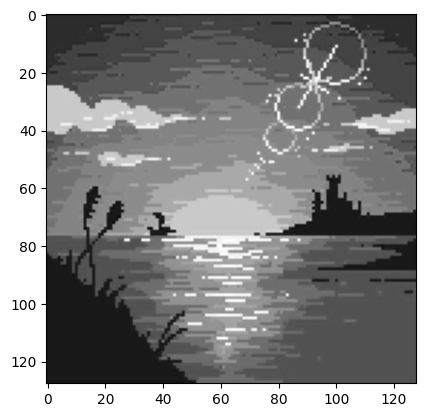

Check if the watermark is the same as the original in the cipher domain:  True
Check if the watermark is the same as the original in the clair domain:  True


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

img = mpimg.imread("128p.jpg")
# Resize the image to 128x128 pixels
img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
# Convert to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# mostrar imagen
plt.imshow(img, cmap="gray")
plt.show()

# Save the image in an array
image = np.array(img)

# Generate a random watermark of 256 bits
w = np.random.randint(0, 2, 256, dtype=int)

# Random message of 256 bits
b = np.random.randint(0, 2, 256, dtype=int)

# Watermark the image
image_watermarked, pub_key, priv_key = watermark_image(image, w, b)

# Check the watermark
# Extract the watermark
b_ext = extraction_ciphered(image_watermarked)

# Check if the watermark is the same as the original
print(
    "Check if the watermark is the same as the original in the cipher domain: ",
    np.array_equal(b, b_ext),
)

# Check if the watermark is the same as the original in the clair domain
b_ext_clair = extraction_clair(image_watermarked, priv_key, pub_key, w)
# Check if the watermark is the same as the original in the clair domain
print(
    "Check if the watermark is the same as the original in the clair domain: ",
    np.array_equal(b, b_ext_clair),
)


Show decrypted watermarked image

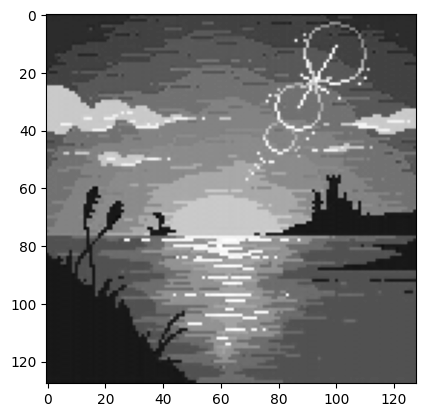

In [118]:
# Show decrypted image
image = image_watermarked.flatten()
# Save 256 bits of the image in a list

image_decrypted = [paillier_decrypt(i, priv_key, pub_key) for i in image]

# Reshape the image to its original dimensions
image_decrypted = np.array(image_decrypted).reshape(128, 128)
# Convert to signed int
image_decrypted = image_decrypted.astype(np.int32)
# Show the image
plt.imshow(image_decrypted, cmap="gray")
plt.show()
